# Proyek Klasifikasi Gambar: [Vegetable Image Dataset]
- **Nama:** [Maylina Nur'aini]
- **Email:** [maylinanuraini@gmail.com]
- **ID Dicoding:** [mc444d5x0679]

## Import Semua Packages/Library yang Digunakan

In [ ]:
import os
import shutil
import zipfile
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from keras.layers import TFSMLayer

## Data Preparation

### Data Loading

In [ ]:
# Upload fie json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"maylina","key":"4decc92f9fb540fa1629609daa8dd070"}'}

In [ ]:
# Unduh dan load dataset apparel
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d misrakahmed/vegetable-image-dataset

import zipfile
with zipfile.ZipFile("vegetable-image-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("vegetable_dataset")

Dataset URL: https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset
License(s): CC-BY-SA-4.0


In [ ]:
# Melihat jumlah citra
def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0
    class_counts = {}

    # Loop direktori utama: train/test/validation
    for main_folder in os.listdir(directory):
        main_folder_path = os.path.join(directory, main_folder)
        if not os.path.isdir(main_folder_path):
            continue

        print(f"\n📂 Folder: {main_folder}")

        # Loop folder per kelas
        for class_folder in os.listdir(main_folder_path):
            class_folder_path = os.path.join(main_folder_path, class_folder)
            if not os.path.isdir(class_folder_path):
                continue

            num_images = 0

            for img_file in os.listdir(class_folder_path):
                img_path = os.path.join(class_folder_path, img_file)
                if os.path.isfile(img_path):
                    try:
                        with Image.open(img_path) as img:
                            unique_sizes.add(img.size)
                            num_images += 1
                            total_images += 1
                    except Exception as e:
                        print(f"Error reading {img_path}: {e}")

            class_counts[f"{main_folder}/{class_folder}"] = num_images
            print(f"- {class_folder}: {num_images} gambar")

    print("\n📏 Resolusi gambar unik:")
    for size in sorted(unique_sizes):
        print(f"- {size}")

    print(f"\n🧮 Total gambar: {total_images}")

# Memanggil fungsi direktori path 'vegetable_dataset'
print_images_resolution("vegetable_dataset/Vegetable Images")


📂 Folder: validation
- Cabbage: 200 gambar
- Pumpkin: 200 gambar
- Potato: 200 gambar
- Bottle_Gourd: 200 gambar
- Bitter_Gourd: 200 gambar
- Tomato: 200 gambar
- Radish: 200 gambar
- Cauliflower: 200 gambar
- Bean: 200 gambar
- Brinjal: 200 gambar
- Capsicum: 200 gambar
- Broccoli: 200 gambar
- Cucumber: 200 gambar
- Carrot: 200 gambar
- Papaya: 200 gambar

📂 Folder: train
- Cabbage: 1000 gambar
- Pumpkin: 1000 gambar
- Potato: 1000 gambar
- Bottle_Gourd: 1000 gambar
- Bitter_Gourd: 1000 gambar
- Tomato: 1000 gambar
- Radish: 1000 gambar
- Cauliflower: 1000 gambar
- Bean: 1000 gambar
- Brinjal: 1000 gambar
- Capsicum: 1000 gambar
- Broccoli: 1000 gambar
- Cucumber: 1000 gambar
- Carrot: 1000 gambar
- Papaya: 1000 gambar

📂 Folder: test
- Cabbage: 200 gambar
- Pumpkin: 200 gambar
- Potato: 200 gambar
- Bottle_Gourd: 200 gambar
- Bitter_Gourd: 200 gambar
- Tomato: 200 gambar
- Radish: 200 gambar
- Cauliflower: 200 gambar
- Bean: 200 gambar
- Brinjal: 200 gambar
- Capsicum: 200 gambar
-

### Data Preprocessing

#### Split Dataset

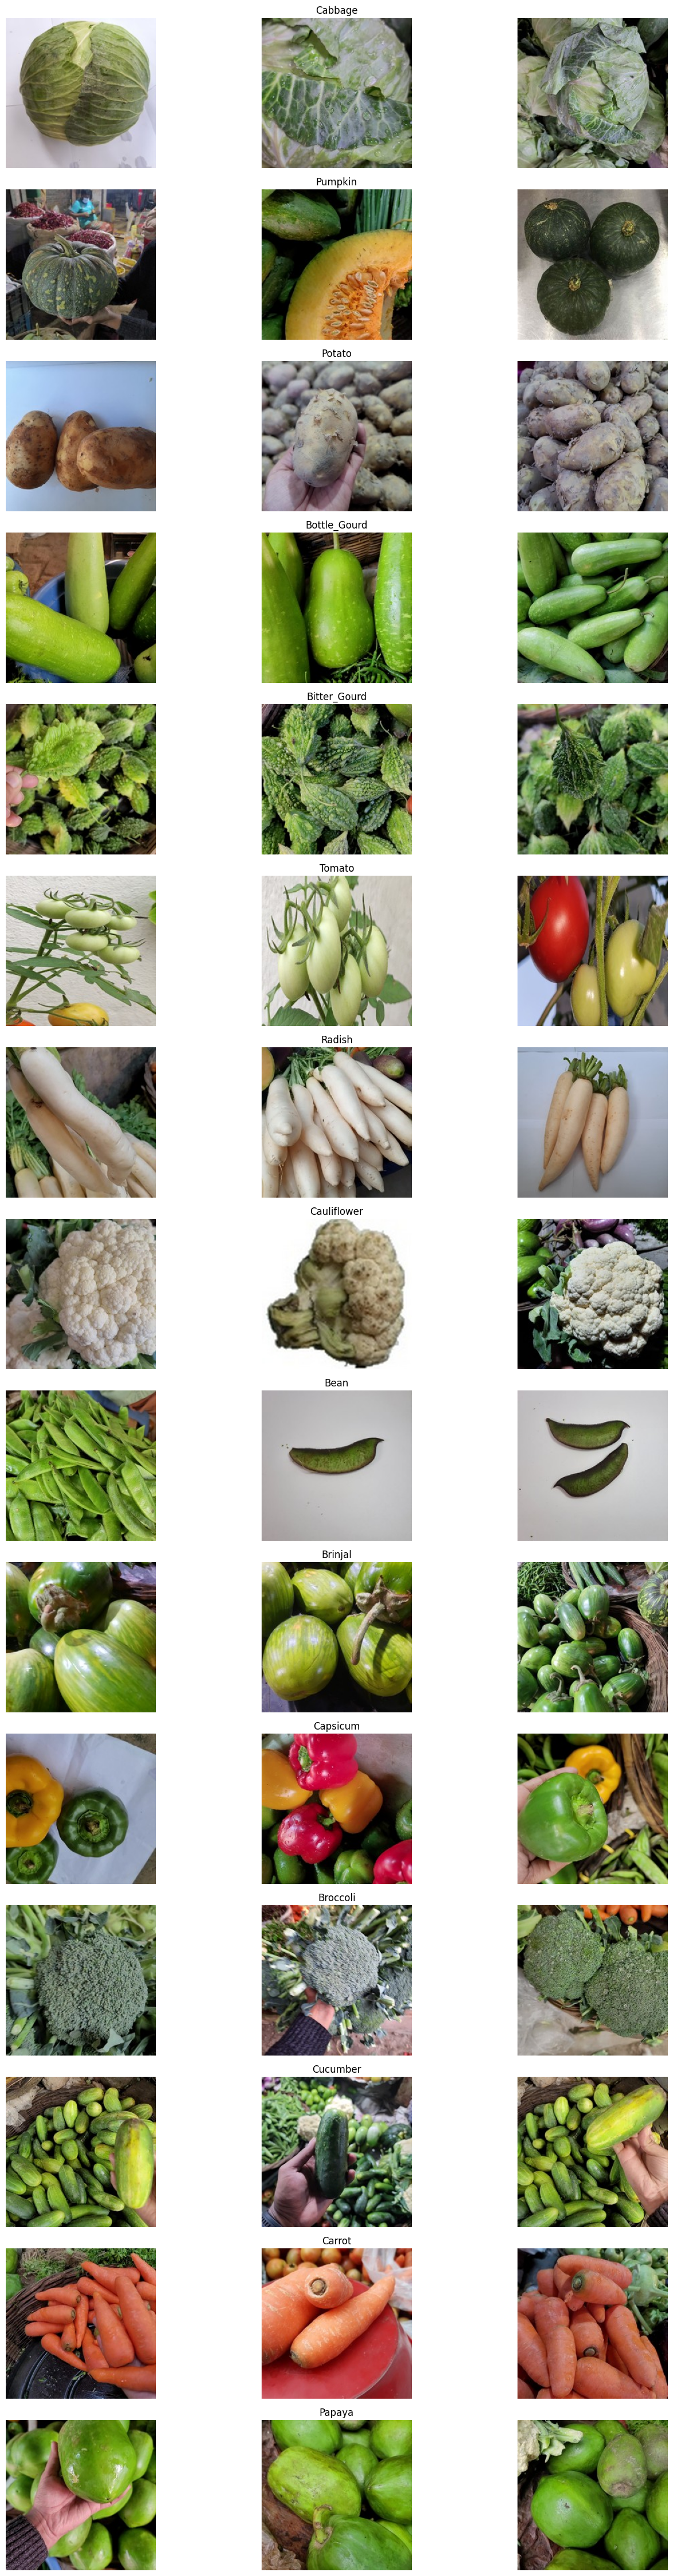

In [ ]:
# Base direktori dan kategori
base_dir = "vegetable_dataset/Vegetable Images/train"
categories = os.listdir(base_dir)
samples_per_class = 3

# Tampilkan 3 gambar acak dari tiap kelas
plt.figure(figsize=(15, len(categories) * 3))
for i, category in enumerate(categories):
    category_path = os.path.join(base_dir, category)
    images = os.listdir(category_path)
    selected_images = random.sample(images, samples_per_class)

    for j, img_name in enumerate(selected_images):
        img_path = os.path.join(category_path, img_name)
        img = mpimg.imread(img_path)

        plt.subplot(len(categories), samples_per_class, i * samples_per_class + j + 1)
        plt.imshow(img)
        plt.axis('off')
        if j == 1:
            plt.title(category, fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
# Membuat folder untuk split data menjadi train, test, dan val
os.makedirs('vegetable_split/train', exist_ok=True)
os.makedirs('vegetable_split/val', exist_ok=True)
os.makedirs('vegetable_split/test', exist_ok=True)

for category in categories:
    images = os.listdir(os.path.join(base_dir, category))
    random.shuffle(images)

    train_split = int(0.7 * len(images))
    val_split = int(0.9 * len(images))

    for phase, image_list in zip(['train', 'val', 'test'],
                                 [images[:train_split], images[train_split:val_split], images[val_split:]]):
        dest_dir = f'vegetable_split/{phase}/{category}'
        os.makedirs(dest_dir, exist_ok=True)
        for img in image_list:
            src = os.path.join(base_dir, category, img)
            dst = os.path.join(dest_dir, img)
            shutil.copyfile(src, dst)

In [ ]:
base_dir = 'vegetable_dataset/vegetable_images'
img_size = 128
batch_size = 32

# Data Augmentation & Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'vegetable_split/train',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    'vegetable_split/val',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    'vegetable_split/test',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 10500 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 1500 images belonging to 15 classes.


## Modelling

In [ ]:
# Pemodelan dengan model sequential, conv2d, dan pooling layer
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         7,695 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,946,511 (49.39 MB)

 Trainable params: 12,946,511 (49.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Callback
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
]

# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 64s 176ms/step - accuracy: 0.3894 - loss: 1.8203 - val_accuracy: 0.6800 - val_loss: 1.0986
Epoch 2/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 73s 163ms/step - accuracy: 0.7285 - loss: 0.8084 - val_accuracy: 0.8140 - val_loss: 0.5389
Epoch 3/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 56s 170ms/step - accuracy: 0.8259 - loss: 0.5205 - val_accuracy: 0.8207 - val_loss: 0.7172
Epoch 4/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 80s 165ms/step - accuracy: 0.8704 - loss: 0.3842 - val_accuracy: 0.9030 - val_loss: 0.3135
Epoch 5/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 84s 170ms/step - accuracy: 0.9013 - loss: 0.2984 - val_accuracy: 0.9080 - val_loss: 0.3123
Epoch 6/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 54s 165ms/step - accuracy: 0.9113 - loss: 0.2725 - val_accuracy: 0.9303 - val_loss: 0.2243
Epoch 7/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 54s 163ms/step - accuracy: 0.9417 - loss: 0.1854 - val_accuracy: 0.9177 - val_loss: 0.2720
Epoch 8/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 55s 169ms/step - accuracy: 0.9401 - loss: 0

## Evaluasi dan Visualisasi

In [20]:
# Setelah training selesai, dan load model terbaik dari .keras
model = tf.keras.models.load_model('best_model.keras')

test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9732 - loss: 0.1156
Test Loss: 0.10065191984176636
Test Accuracy: 0.9726666808128357


In [21]:
# Mengambil riwayat akurasi train dari objek history
train_accuracy = history.history['accuracy']

# Menampilkan akurasi train
print(f"Akurasi Train: {train_accuracy[-1] * 100:.2f}%")

Akurasi Train: 97.65%


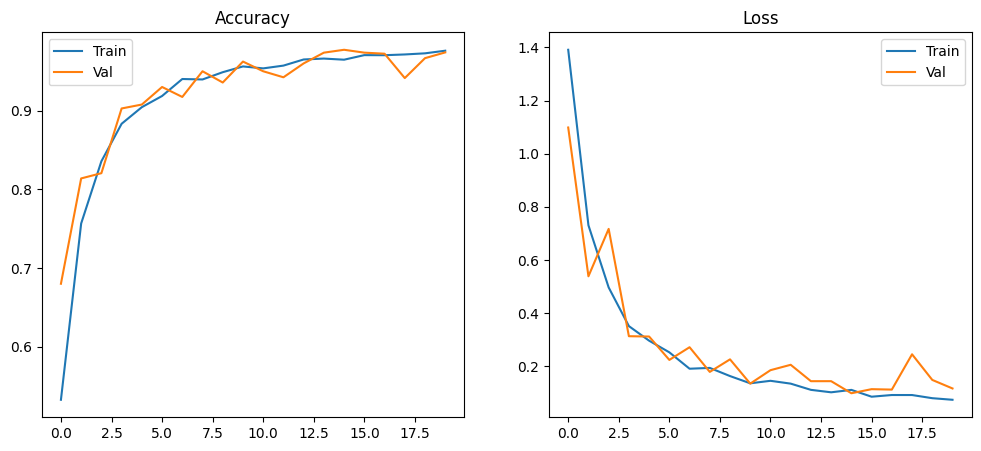

In [22]:
# Membuat dan melihat plot akurasi dan loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("Loss")
plt.legend()
plt.show()

## Konversi Model

In [23]:
# Menyimpan ke format save model
model.export('saved_model/vegetable_model')

Saved artifact at 'saved_model/vegetable_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  133689131438864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133689131445008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133689131445200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133689054070352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133689054069776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133689054071120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133689054070928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133689054072464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133689054071888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133689054073232: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [24]:
# Simpan label ke file label.txt
labels = list(train_generator.class_indices.keys())
with open("label.txt", "w") as f:
    for label in labels:
        f.write(label + "\n")

# Konversi model ke format TFLite
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model("saved_model/vegetable_model")
tflite_model = converter.convert()

# Simpan model TFLite ke file
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ Model berhasil dikonversi ke TensorFlow Lite.")

✅ Model berhasil dikonversi ke TensorFlow Lite.


In [25]:
# Instal TensorFlow.js
!pip install tensorflowjs

# Buat folder untuk menyimpan model TFJS
!mkdir -p tfjs_model

# Konversi model dari SavedModel ke TFJS
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    saved_model/vegetable_model tfjs_model

# Print pesan berhasil
print("✅ Model berhasil dikonversi ke TensorFlow.js.")

2025-04-24 08:19:30.533437: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745482770.554013   14045 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745482770.560275   14045 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-24 08:19:35.321085: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1745482775.321256   14045 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

## Inference (Optional)

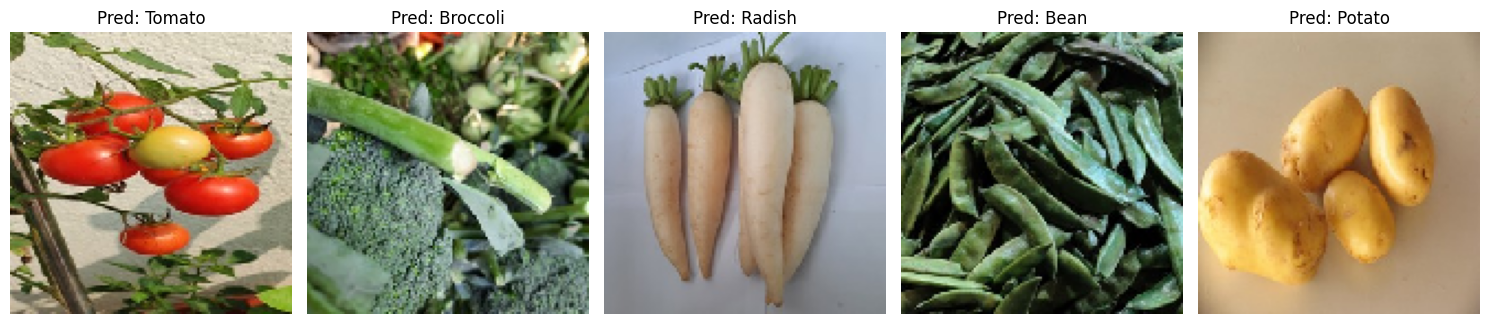

In [34]:
# Load model menggunakan TFSMLayer
model = TFSMLayer('saved_model/vegetable_model', call_endpoint='serve')

# Load label
with open("label.txt", "r") as f:
    labels = [line.strip() for line in f.readlines()]

# Ambil 5 gambar acak dari test folder
test_folder = 'vegetable_split/test'
all_classes = os.listdir(test_folder)
random_images = []

for _ in range(5):
    cls = random.choice(all_classes)
    img_file = random.choice(os.listdir(os.path.join(test_folder, cls)))
    img_path = os.path.join(test_folder, cls, img_file)
    random_images.append(img_path)

# Prediksi dan tampilkan
plt.figure(figsize=(15, 5))
for i, img_path in enumerate(random_images):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model(img_array)
    pred_label = labels[np.argmax(pred)]

    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"Pred: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

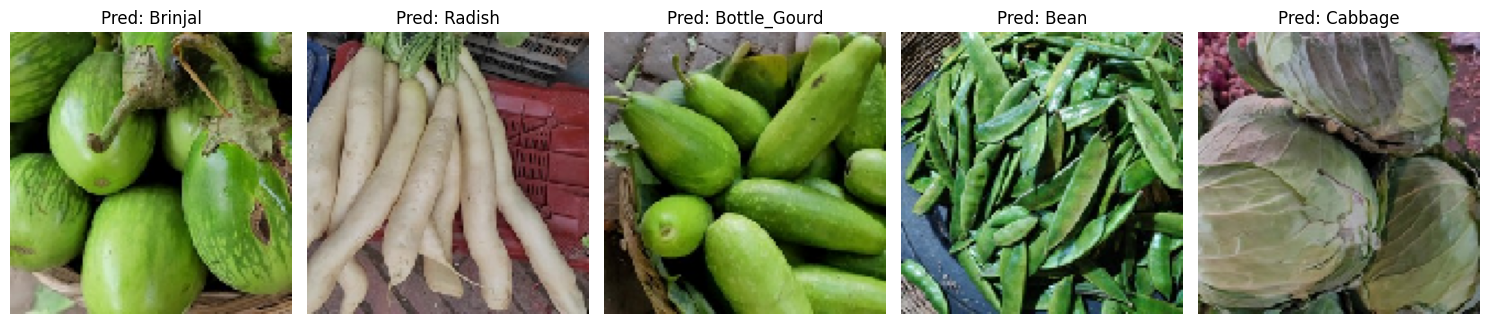

In [38]:
# Load TFLite model
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load label
with open("label.txt", "r") as f:
    labels = [line.strip() for line in f.readlines()]

# Ambil 5 gambar acak dari test folder
test_folder = 'vegetable_split/test'
all_classes = os.listdir(test_folder)
random_images = []

for _ in range(5):
    cls = random.choice(all_classes)
    img_file = random.choice(os.listdir(os.path.join(test_folder, cls)))
    img_path = os.path.join(test_folder, cls, img_file)
    random_images.append(img_path)

# Prediksi dan tampilkan
plt.figure(figsize=(15, 5))
for i, img_path in enumerate(random_images):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0).astype(np.float32)

    interpreter.set_tensor(input_details[0]['index'], img_array)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    pred_label = labels[np.argmax(output)]

    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"Pred: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()